In [54]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

In [55]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return np.array(images, dtype=object)

In [56]:
#follow the ration 60% 20% 20%
TRAINING_SIZE = 114
VALIDATION_SIZE = 38
TEST_SIZE = 38

TRAINING_OFFSET = TRAINING_SIZE
VALIDATION_OFFSET = TRAINING_OFFSET + VALIDATION_SIZE

training_set = []
validation_set = []
test_set = []

for i in range (1, 10):
    class_i_images = load_images_from_folder("ACdata_base/" + str(i))
    training_set.append(class_i_images[0:TRAINING_OFFSET])
    validation_set.append(class_i_images[TRAINING_OFFSET: VALIDATION_OFFSET])
    test_set.append(class_i_images[VALIDATION_OFFSET:])

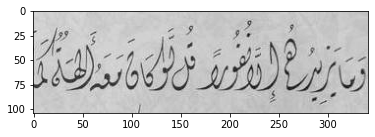

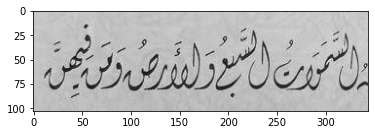

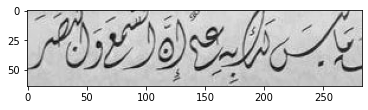

In [57]:
plt.imshow(training_set[0][TRAINING_SIZE-1],cmap='gray')
plt.show()

plt.imshow(validation_set[0][0],cmap='gray')
plt.show()

plt.imshow(test_set[0][TEST_SIZE-1],cmap='gray')
plt.show()